<a href="https://colab.research.google.com/github/martinoywa/zindi-challenges/blob/main/Road%20Segment%20Identification/PyTorch_FineTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms as transforms
from torchvision.datasets import ImageFolder

import os
import shutil
from PIL import Image
import time

In [2]:
# import requests
# import requests, zipfile


# url = "https://api.zindi.africa/v1/competitions/road-segment-identification/files/Images.zip"
# token = {"auth_token":"1KJ4bWkMiaWnz2RWgNnjNVtZ"}

# x = requests.post(url, data = token,stream=True)
# target_path = 'Images.zip'

# handle = open(target_path, "wb")
# for chunk in x.iter_content(chunk_size=512):
#     if chunk:  # filter out keep-alive new chunks
#         handle.write(chunk)
# handle.close()

# !unzip -qq /content/Images.zip


In [3]:
device = "device" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# data splitting
os.makedirs("data/train/0")
os.makedirs("data/train/1")
os.makedirs("data/test/test")

In [5]:
train_data = pd.read_csv("Train.csv")
train_data.head()

,Image_ID,Target
0,ID_0073qfb8,0
1,ID_00gy3vH2,1
2,ID_00uB3UFr,0
3,ID_012xZpNw,1
4,ID_014GgMRb,1


In [5]:
files = []
for (root, dirs, file ) in os.walk("Images"):
    files += file

In [6]:
# copy to data
image_ids = train_data["Image_ID"].values
for i in range(len(files)):
    if files[i][:-4] in image_ids:
        shutil.copy("Images/"+files[i], "data/train/"+str(train_data.loc[train_data["Image_ID"] == files[i][:-4]]["Target"].values[0]))

In [7]:
test_data = pd.read_csv("Test.csv")
# copy to data
image_ids_test = test_data["Image_ID"].values
for i in range(len(files)):
    if files[i][:-4] in image_ids_test:
        shutil.copy("Images/"+files[i], "data/test/test")

In [2]:
# preprocessing
transform = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data sets
trainset = ImageFolder("data/train/", transform=transform)
testset = ImageFolder("data/test/", transform=transform)

# data loading
trainloader = DataLoader(trainset, shuffle=True, batch_size=32)
testloader = DataLoader(testset, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


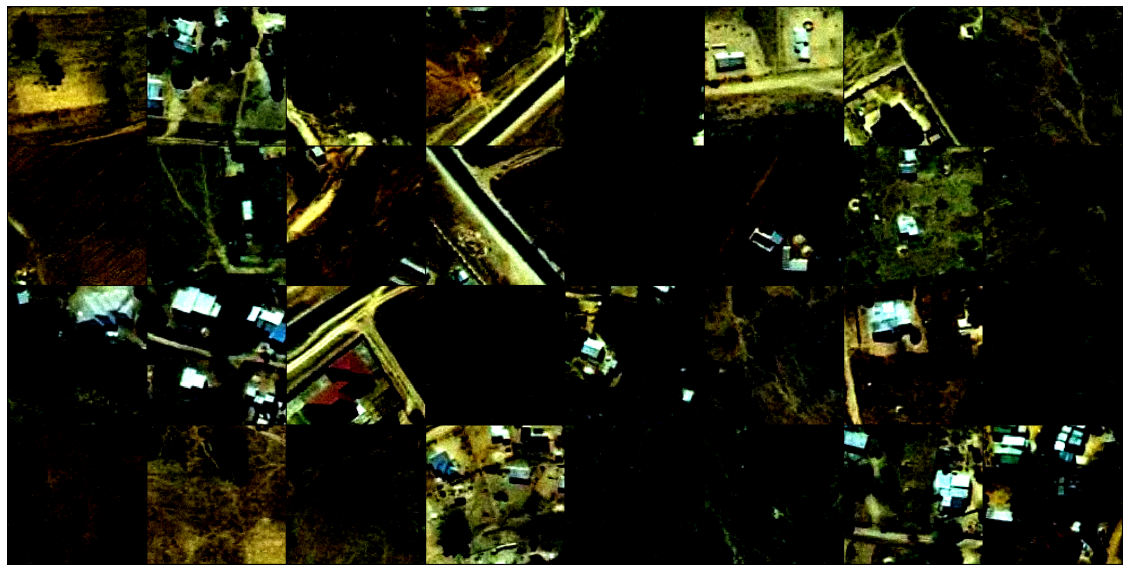

tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1])


In [3]:
# data visualization
dataiter = iter(trainloader)
images, labels = dataiter.next()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
plt.figure(figsize=(20, 20))
plt.axis('off')
imshow(torchvision.utils.make_grid(images))
print(labels)

# Model Finetuning

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# ML Process
# 1. Model Definition
class ArmyNet(nn.Module):
    def __init__(self):
        super().__init__()
        # cnn
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        # pooling
        self.pool = nn.MaxPool2d((2,2))
        # linear
        self.fc1 = nn.Linear(32*53*53, 1024)
        self.fc2 = nn.Linear(1024, 2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

model = ArmyNet()
model.to(device)

In [7]:
# 2. Hyperparameter Definition
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [8]:
# 3. Model Training
def train(model, epochs, trainloader, criterion, optimizer):
    for epoch in range(epochs):
        start = time.time()
        running_loss = 0.0
        correct = 0.0
        
        model.train()
        for batch, (data, labels) in enumerate(trainloader):
            data, labels = data.to(device), labels.to(device)
            
            # optimizer
            optimizer.zero_grad()
            # output
            output = model.forward(data)
            # loss
            loss = criterion(output, labels)
            running_loss += loss.item()
            # back propagation and update
            loss.backward()
            optimizer.step()
            # calculate accuracy
            _, preds = torch.max(output, 1)
            correct += torch.sum(preds == labels.data).item()
            
        stop = time.time()
        # logging
        accuracy = 100*(correct/len(trainloader.dataset))
        print(f"Epoch: {epoch+1}, Train Loss: {running_loss/len(trainloader.dataset):.4f}, Train Accuracy: {accuracy:.4f}, Time: {stop-start} s")
        running_loss = 0.0

Epoch: 1, Train Loss: 20.712
Epoch: 2, Train Loss: 17.693
Epoch: 3, Train Loss: 17.058
Epoch: 4, Train Loss: 16.728
Epoch: 5, Train Loss: 15.824
Epoch: 6, Train Loss: 14.861
Epoch: 7, Train Loss: 13.900
Epoch: 8, Train Loss: 12.721
Epoch: 9, Train Loss: 12.284
Epoch: 10, Train Loss: 11.741


In [ ]:
# train
train(model, 10, trainloader, criterion, optimizer)

In [9]:
# save model weights
torch.save(model.state_dict(), "model.pt")

In [10]:
# 4. Model Evaluation
def test(model, testloader):
    model.eval()
    test_loss = 0.0
    # correct = 0.0
    
    for batch, (data, labels) in enumerate(testloader):
        data, labels = data.to(device), labels.to(device)
        output = model.forward(data)
        loss = criterion(output, labels)
        test_loss += loss.item()
        
        # calculate accuracy
        # _, preds = torch.max(output, 1)
        # correct += torch.sum(preds == labels.data).item()
        
    # logging
    # accuracy = 100*(correct/len(testloader.dataset))
    print(f"Test Loss: {test_loss/len(testloader.dataset):.4f}") #, Test Accuracy: {accuracy:.4f}")

In [11]:
# evaluate
test(model, testloader)

,Image_ID,Target
0,ID_01c6i2wd,0.794829
1,ID_03sPqBLY,0.894072
2,ID_06ZKUQFl,0.878947
3,ID_06gzqIwK,0.813930
4,ID_08kWat36,0.824734
...,...,...
2995,ID_zxBFKP2n,0.792099
2996,ID_zxN7nQbW,0.885765
2997,ID_zyWc0ENM,0.878402
2998,ID_zywRGuyq,0.845216


In [24]:
# submission
submission = pd.read_csv("SampleSubmission.csv")
submission.head()

In [ ]:
for id in submission["Image_id"]:
    image = Image.open(f"data//test//test\\{id}.jpg")
    image_t = transform(image).unsqueeze(0)
    # print(model.forward(image_t))
    submission.loc[submission["Image_id"] == id, "Label"] = torch.argmax(model.forward(image_t)).item()

In [ ]:
submission.to_csv("submission.csv", index=False)